In [1]:
cd /om2/user/leokoz8/code/rnns-of-rnns

/rdma/vast-rdma/vast/fiete/leokoz8/code/rnns-of-rnns


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F

from src import models, utils

%load_ext autoreload
%autoreload 2

Download MNIST dataset

torch.Size([60000, 28, 28])
torch.Size([60000])


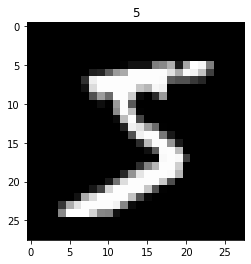

/om/user/leokoz8/envs/rnns-of-rnns-env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/om/user/leokoz8/envs/rnns-of-rnns-env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [7]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

          # learning rate
DOWNLOAD_MNIST = False   # set to True if haven't download the data
BATCH_SIZE = 64

# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy()[:2000]    # covert to numpy array

In [ ]:
ns = [32,32,8]

A_tril = torch.zeros((len(ns), len(ns)))
A_tril[-1, :] = 1
B_mask = F.dropout(utils.create_mask_given_A(A_tril, ns), 0.9) 
W_hh,Ws = utils.create_random_block_stable_symmetric_weights(ns)
M_hat = utils.get_M_given_sym_W(W_hh)

param_dict = {"ns": ns,
              "W_hh": W_hh,
              "W_ih": None,
              "W_ho": None,
              "M_hat": M_hat,
              "B_mask": B_mask,              
             "input_size": int(28),
             "output_size": 10,
             "nonlinearity": 'tanh',
             "gamma": 1,
             "alpha": 0.01}



rnn = models.GWRNN(param_dict)


In [133]:


EPOCH = 5  
LR = 0.01   
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    
    for step, (b_x, b_y) in enumerate(train_loader):        # gives batch data
        b_x = b_x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output[:,-1,:], b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output[:,-1,:], 1)[1].data.numpy()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

          
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output[:,-1,:], 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')


Epoch:  0 | train loss: 2.2894 | test accuracy: 0.10
Epoch:  0 | train loss: 1.9756 | test accuracy: 0.34
Epoch:  0 | train loss: 1.6072 | test accuracy: 0.44
Epoch:  0 | train loss: 1.2956 | test accuracy: 0.50
Epoch:  0 | train loss: 1.1534 | test accuracy: 0.60
Epoch:  0 | train loss: 1.0513 | test accuracy: 0.66
Epoch:  0 | train loss: 0.7630 | test accuracy: 0.69
Epoch:  0 | train loss: 0.7262 | test accuracy: 0.73
Epoch:  0 | train loss: 0.7630 | test accuracy: 0.76
Epoch:  0 | train loss: 0.7605 | test accuracy: 0.78
Epoch:  0 | train loss: 0.7784 | test accuracy: 0.80
Epoch:  0 | train loss: 0.4850 | test accuracy: 0.79
Epoch:  0 | train loss: 0.6633 | test accuracy: 0.81
Epoch:  0 | train loss: 0.5676 | test accuracy: 0.81
Epoch:  0 | train loss: 0.3777 | test accuracy: 0.82
Epoch:  0 | train loss: 0.5048 | test accuracy: 0.83
Epoch:  0 | train loss: 0.5456 | test accuracy: 0.85
Epoch:  0 | train loss: 0.3041 | test accuracy: 0.85
Epoch:  0 | train loss: 0.6433 | test accuracy

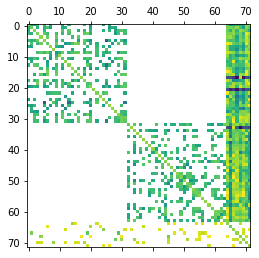

In [134]:
with torch.no_grad():
    plt.matshow(torch.log(torch.abs(rnn.rnn.weight_hh) + torch.abs(rnn.L_hat.weight))+0.01)